<a href="https://colab.research.google.com/github/mrrahul011/EIP-Session-5/blob/master/Assignment_5V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv1D, Conv2D, BatchNormalization, Activation,Dropout
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten,GlobalAveragePooling2D,SeparableConv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=16, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [8]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
13113,resized/13115.jpg,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
13471,resized/13473.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0
4833,resized/4834.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
11221,resized/11223.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
490,resized/491.jpg,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(train_df, batch_size=64, shuffle=False)

In [10]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
input_shape = (224,224,3)

In [12]:

inputs = Input(shape=input_shape)

num_filters = 32
z = Conv2D(num_filters,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
z = Activation('relu')(z)
z= Conv2D(32,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = MaxPooling2D(pool_size=(2,2),strides=(2,2))(z)

z = Conv2D(64,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = Conv2D(64,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = MaxPooling2D(pool_size=(2,2),strides=(2,2))(z)

z = SeparableConv2D(128,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = SeparableConv2D(128,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = MaxPooling2D(pool_size=(2,2),strides=(2,2))(z)

z = SeparableConv2D(256,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = SeparableConv2D(256,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
z = Activation('relu')(z)
z = BatchNormalization()(z)

z = Conv2D(16,
           kernel_size=1,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)

In [13]:
# Network architecture params.
num_classes = 10
num_filters = 16
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

# Start model definition.

x = Conv2D(num_filters,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(z)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks-1):
        strides = 1
        #is_first_layer_but_not_first_block = j == 0 and i > 0
        #if is_first_layer_but_not_first_block:
        if (j == 0 and i>0):
            strides = 2
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        #if is_first_layer_but_not_first_block:
        if (j == 0 and i>0):
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters


x = GlobalAveragePooling2D()(x)
neck = x


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck




def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=inputs, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        activation_1[0][0]               
____________________________________________________________________________________________

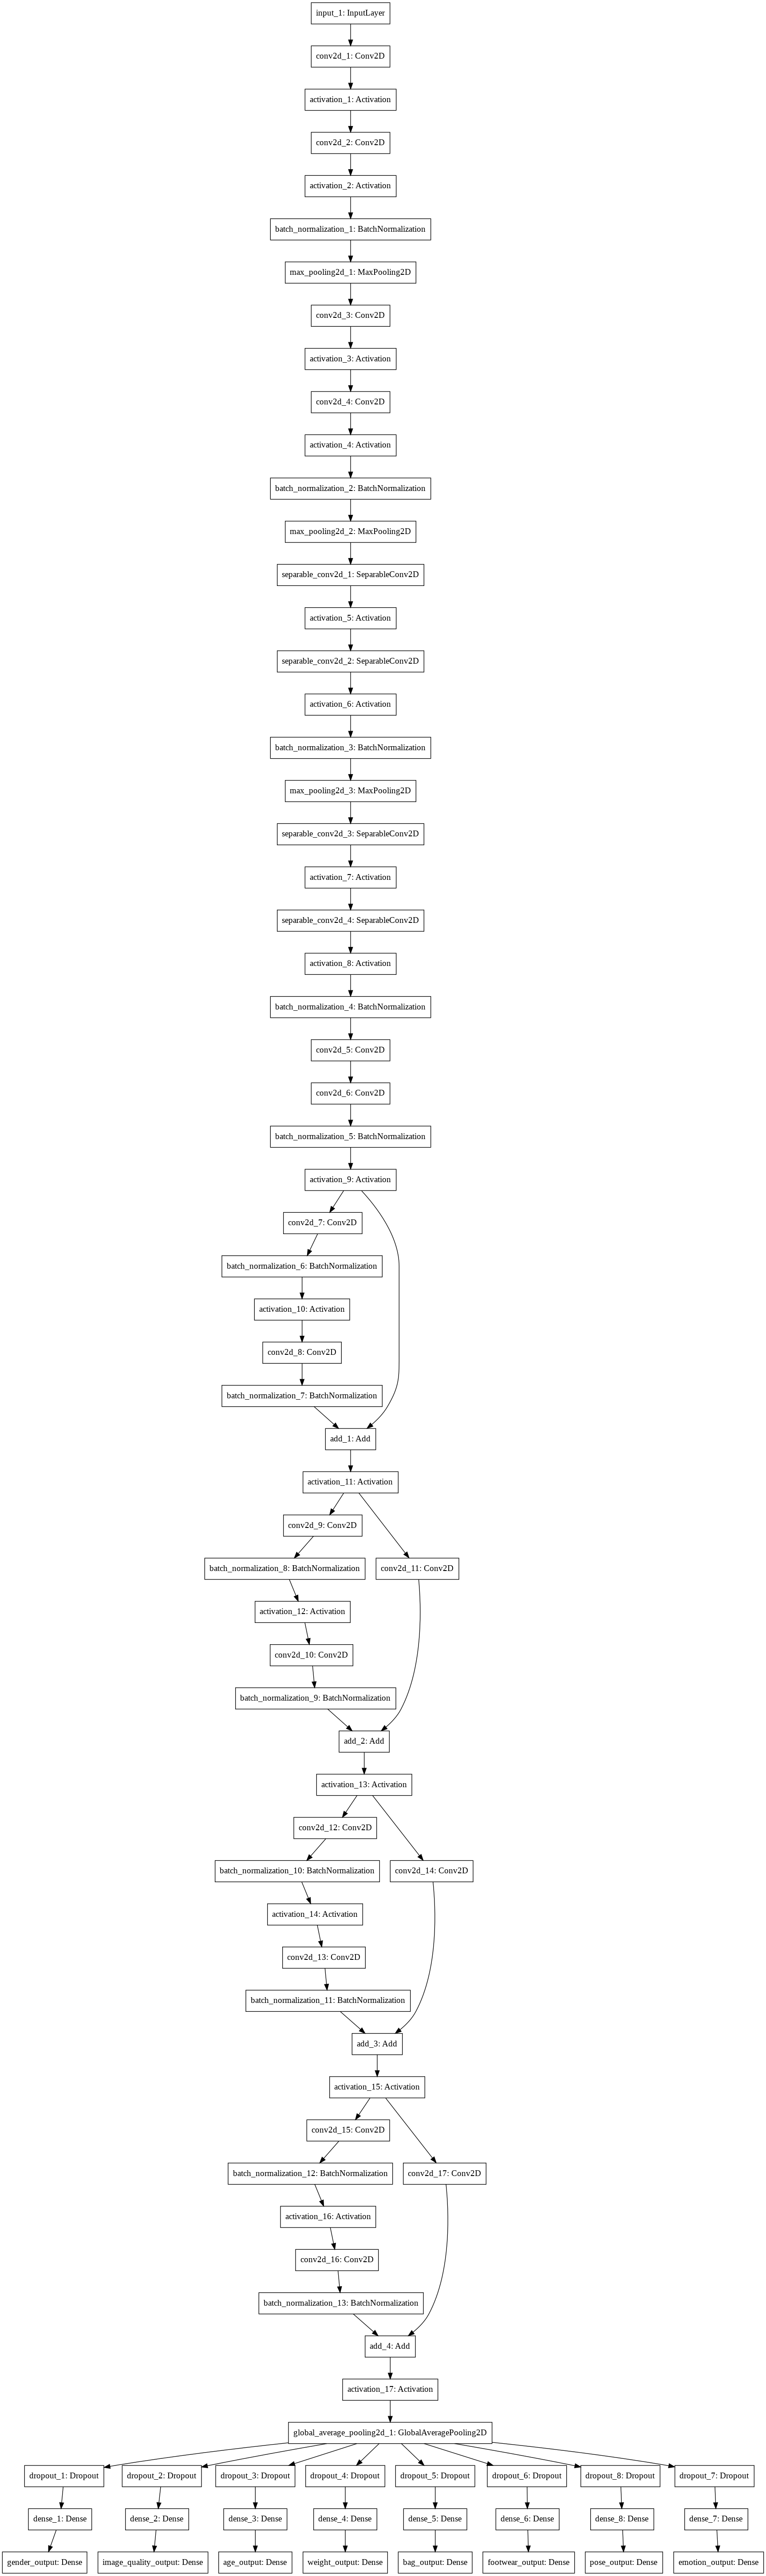

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])

In [29]:

# Train the model
model_info=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1
)


Epoch 1/50
360/360 [==============================] - 72s 200ms/step - loss: 1.7885 - gender_output_loss: 0.0441 - image_quality_output_loss: 0.1762 - age_output_loss: 0.2391 - weight_output_loss: 0.1709 - bag_output_loss: 0.1160 - footwear_output_loss: 0.1174 - pose_output_loss: 0.0636 - emotion_output_loss: 0.1618 - gender_output_acc: 0.9841 - image_quality_output_acc: 0.9297 - age_output_acc: 0.9128 - weight_output_acc: 0.9350 - bag_output_acc: 0.9560 - footwear_output_acc: 0.9563 - pose_output_acc: 0.9767 - emotion_output_acc: 0.9406 - val_loss: 1.2178 - val_gender_output_loss: 0.0236 - val_image_quality_output_loss: 0.0817 - val_age_output_loss: 0.1115 - val_weight_output_loss: 0.1020 - val_bag_output_loss: 0.0520 - val_footwear_output_loss: 0.0538 - val_pose_output_loss: 0.0245 - val_emotion_output_loss: 0.0668 - val_gender_output_acc: 0.9911 - val_image_quality_output_acc: 0.9727 - val_age_output_acc: 0.9639 - val_weight_output_acc: 0.9652 - val_bag_output_acc: 0.9837 - val_foot